In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string

def generate_synthetic_data(rows=1000, cols=20, seed=42):  # Reduced cols for cleaner data
    """
    Generates a synthetic DataFrame with mixed data types focusing on numeric features
    """
    np.random.seed(seed)
    random.seed(seed)

    # More emphasis on numeric columns
    col_types = ['int', 'float', 'category']  # Removed text and boolean for simplicity
    type_counts = {k: cols // len(col_types) for k in col_types}
    
    data = {}
    
    # Generate more meaningful features
    for i in range(type_counts['int']):
        base = np.random.randint(0, 100, size=rows)
        noise = np.random.normal(0, 0.1, size=rows)  # Add small noise
        data[f'int_col_{i}'] = base + noise
    
    for i in range(type_counts['float']):
        base = np.random.normal(50, 10, size=rows)  # More controlled distribution
        data[f'float_col_{i}'] = base
    
    for i in range(type_counts['category']):
        data[f'cat_col_{i}'] = pd.Series(np.random.choice(['A', 'B', 'C'], size=rows, p=[0.4, 0.3, 0.3])).astype("category")
    
    # Generate target with actual relationships to features
    target = np.zeros(rows)
    for col in data:
        if 'int_col' in col or 'float_col' in col:
            coef = np.random.uniform(-2, 2)  # Random coefficient
            target += coef * data[col]
    
    # Add some noise to target
    target += np.random.normal(0, 1, size=rows)
    data['target'] = target

    return pd.DataFrame(data)

# Generate and preview
main_df = generate_synthetic_data()
df = main_df.copy()
df.head()

,int_col_0,int_col_1,int_col_2,int_col_3,int_col_4,int_col_5,float_col_0,float_col_1,float_col_2,float_col_3,float_col_4,float_col_5,cat_col_0,cat_col_1,cat_col_2,cat_col_3,cat_col_4,cat_col_5,target
0,51.152312,78.852267,11.826997,93.933580,24.889823,27.054409,31.657040,56.707965,51.076688,49.648667,42.387355,37.716219,A,C,C,B,B,B,-220.505994
1,92.053891,57.025776,16.188328,76.809373,8.998502,0.744172,41.932233,58.067048,27.282955,54.714521,48.181502,50.559671,C,B,B,A,B,B,-331.790216
2,13.896275,54.148124,36.975556,48.042918,29.902016,56.004541,46.458553,43.560949,62.175111,27.379197,43.801655,56.045759,A,A,A,B,A,C,-199.327099
3,70.980966,2.952142,79.899864,1.083164,96.065413,55.987860,43.242100,49.661263,44.028569,63.318086,55.023427,48.613032,B,B,B,C,A,A,-386.066617
4,59.912438,23.059806,76.864167,46.977837,27.928478,32.877836,51.161683,35.566085,50.667403,76.462309,59.295256,40.531614,A,C,B,C,C,A,-356.838649


In [2]:
def convert_str_to_numeric(df, errors='coerce'):
    """
    Converts columns with strings that look like numbers into numeric dtype.
    `errors='coerce'` will convert invalid parsing to NaN.
    """
    df_converted = df.copy()
    for col in df_converted.columns:
        if df_converted[col].dtype == object:
            try:
                df_converted[col] = pd.to_numeric(df_converted[col], errors=errors)
            except:
                pass
    return df_converted

def lowercase_string_columns(df):
    """
    Lowercases all string (object) column values.
    """
    df_cleaned = df.copy()
    str_cols = df_cleaned.select_dtypes(include='object').columns
    for col in str_cols:
        df_cleaned[col] = df_cleaned[col].astype(str).str.lower().str.strip()
    return df_cleaned

def handle_boolean_columns(df):
    """
    Converts columns with boolean-looking strings or integers into proper bool dtype.
    """
    df_bool = df.copy()
    for col in df_bool.columns:
        if df_bool[col].dtype == object:
            unique_vals = df_bool[col].dropna().astype(str).str.lower().unique()
            if set(unique_vals).issubset({'true', 'false', 'yes', 'no', '1', '0'}):
                df_bool[col] = df_bool[col].astype(str).str.lower().map({
                    'true': True, '1': True, 'yes': True,
                    'false': False, '0': False, 'no': False
                })
        elif df_bool[col].dtype in [int, float] and set(df_bool[col].dropna().unique()).issubset({0, 1}):
            df_bool[col] = df_bool[col].astype(bool)
    return df_bool


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def normalize_minmax(df, columns=None):
    """Applies Min-Max normalization to selected numeric columns."""
    df_norm = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()
    df_norm[columns] = scaler.fit_transform(df_norm[columns])
    return df_norm

def standardize_zscore(df, columns=None):
    """Standardizes selected numeric columns using Z-score (mean=0, std=1)."""
    df_scaled = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    df_scaled[columns] = scaler.fit_transform(df_scaled[columns])
    return df_scaled

def robust_scale(df, columns=None):
    """Applies robust scaling using median and IQR (resistant to outliers)."""
    df_robust = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    scaler = RobustScaler()
    df_robust[columns] = scaler.fit_transform(df_robust[columns])
    return df_robust

def log_transform(df, columns=None, add_constant=True):
    """
    Applies log transformation to selected numeric columns.
    - add_constant: Add 1 to avoid log(0) if True.
    """
    df_log = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    for col in columns:
        try:
            if add_constant:
                df_log[col] = np.log1p(df_log[col])  # log(1 + x)
            else:
                df_log[col] = np.log(df_log[col])
        except Exception as e:
            print(f"Skipping log transform on {col} due to error: {e}")
    return df_log

def drop_duplicates(df):
    """Remove duplicate rows from the DataFrame."""
    return df.drop_duplicates()

def drop_constant_columns(df):
    """Remove columns with only a single unique value."""
    return df.loc[:, df.apply(lambda col: col.nunique(dropna=False) > 1)]

def drop_columns_by_null_threshold(df, threshold=0.5):
    """
    Drop columns with missing values above the given threshold.
    - threshold (float): Max allowable proportion of nulls (0 to 1).
    """
    null_fraction = df.isnull().mean()
    cols_to_keep = null_fraction[null_fraction <= threshold].index
    return df[cols_to_keep]

def impute_missing_values(df, strategy="mean"):
    """
    Fill missing values in numeric and categorical columns.
    - strategy (str): 'mean', 'median', or 'mode'.
    """
    df_clean = df.copy()
    
    for col in df.columns:
        if df[col].isnull().sum() == 0:
            continue
        
        if pd.api.types.is_numeric_dtype(df[col]):
            if strategy == "mean":
                fill_value = df[col].mean()
            elif strategy == "median":
                fill_value = df[col].median()
            elif strategy == "mode":
                fill_value = df[col].mode()[0]
            else:
                raise ValueError("strategy must be one of: 'mean', 'median', 'mode'")
            df_clean[col] = df[col].fillna(fill_value)
        else:
            # Categorical or text-based column: use mode only
            fill_value = df[col].mode()[0]
            df_clean[col] = df[col].fillna(fill_value)
    
    return df_clean

def strip_whitespace_string_columns(df):
    """Trim whitespace in string or object-type columns."""
    df_clean = df.copy()
    str_cols = df_clean.select_dtypes(include=["object", "string"]).columns
    for col in str_cols:
        df_clean[col] = df_clean[col].astype(str).str.strip()
    return df_clean

c:\Users\varun\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

def split_regression_data(df, target_col, method="random", test_size=0.2, stratify_bins=10, time_col=None, n_clusters=5, random_state=42):
    """
    Split regression dataset using different strategies: random, stratified, time-based, or cluster-based.

    Parameters:
    - df (pd.DataFrame): Input dataset.
    - target_col (str): Name of the regression target column.
    - method (str): One of ['random', 'stratified', 'time', 'cluster'].
    - test_size (float): Proportion of test set.
    - stratify_bins (int): Number of quantile bins for stratified splitting.
    - time_col (str): Column for time-based split (required for 'time' method).
    - n_clusters (int): Number of clusters for cluster-based split.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - train_df (pd.DataFrame): Training data.
    - test_df (pd.DataFrame): Testing data.
    """
    df = df.dropna(subset=[target_col]).copy()

    if method == "random":
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    elif method == "stratified":
        # Bin the target column for stratification
        stratify_labels = pd.qcut(df[target_col], q=stratify_bins, duplicates="drop")
        train_df, test_df = train_test_split(df, test_size=test_size, stratify=stratify_labels, random_state=random_state)

    elif method == "time":
        if time_col is None:
            raise ValueError("`time_col` must be provided for time-based splitting.")
        df = df.sort_values(time_col)
        split_idx = int((1 - test_size) * len(df))
        train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]

    elif method == "cluster":
        feature_cols = df.drop(columns=[target_col]).select_dtypes(include=np.number).columns
        if len(feature_cols) == 0:
            raise ValueError("Cluster-based splitting requires numerical features.")

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[feature_cols])

        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        df["cluster"] = kmeans.fit_predict(X_scaled)

        # Stratified split using cluster labels
        train_df, test_df = train_test_split(df, test_size=test_size, stratify=df["cluster"], random_state=random_state)
        df.drop(columns=["cluster"], inplace=True)

    else:
        raise ValueError(f"Invalid split method: {method}. Choose from ['random', 'stratified', 'time', 'cluster'].")

    return train_df, test_df

In [5]:
# Prepare data
df = drop_duplicates(df)
df = drop_constant_columns(df)
df = impute_missing_values(df, strategy="median")

# Split data
train, test = split_regression_data(df, target_col='target', method='random', test_size=0.2, random_state=42)
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

In [6]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
import numpy as np
import pandas as pd

# Function to check available parameters for a model
def get_model_params(model_name):
    """
    Returns all available parameters for the given model.
    
    Parameters:
    - model_name: str, Name of the model to check parameters for
    
    Returns:
    - dict: Available parameters and their default values
    """
    model_dict = {
        "LinearRegression": LinearRegression(),
        "LogisticRegression": LogisticRegression(),
        "Lasso": Lasso(),
        "Ridge": Ridge(),
        "ElasticNet": ElasticNet(),
        "RandomForest": RandomForestRegressor(),
        "Bagging": BaggingRegressor(),
        "GradientBoosting": GradientBoostingRegressor(),
        "AdaBoost": AdaBoostRegressor(),
        "XGBoost": xgb.XGBRegressor(),
        "KNeighbors": KNeighborsRegressor(),
        "SVR": SVR()
    }

    model = model_dict.get(model_name)
    if model is None:
        raise ValueError(f"Model '{model_name}' is not supported.")

    return model.get_params()

# Function to create models with customizable parameters
def create_model(model_name, params=None):
    """
    Creates a machine learning model based on the input model name and optional hyperparameters.
    Available models: LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet, 
                      RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor,
                      AdaBoostRegressor, XGBRegressor, KNeighborsRegressor, SVR.

    Parameters:
    - model_name: str, Name of the model to create
    - params: dict, Hyperparameters to pass to the model (default=None)
    
    Returns:
    - model: scikit-learn or XGBoost model
    """
    params = params or {}

    if model_name == "LinearRegression":
        return LinearRegression(**params)
    elif model_name == "LogisticRegression":
        return LogisticRegression(**params)
    elif model_name == "Lasso":
        return Lasso(**params)
    elif model_name == "Ridge":
        return Ridge(**params)
    elif model_name == "ElasticNet":
        return ElasticNet(**params)
    elif model_name == "RandomForest":
        return RandomForestRegressor(**params)
    elif model_name == "Bagging":
        return BaggingRegressor(**params)
    elif model_name == "GradientBoosting":
        return GradientBoostingRegressor(**params)
    elif model_name == "AdaBoost":
        return AdaBoostRegressor(**params)
    elif model_name == "XGBoost":
        return xgb.XGBRegressor(**params)
    elif model_name == "KNeighbors":
        return KNeighborsRegressor(**params)
    elif model_name == "SVR":
        return SVR(**params)
    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

In [7]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

# Function for Hyperparameter Tuning using RandomizedSearchCV
def hyperparameter_tuning_randomized(model, param_distributions, X_train, y_train, n_iter=100, cv=5, random_state=42):
    """
    Performs hyperparameter tuning using RandomizedSearchCV.
    
    Parameters:
    - model: Machine learning model to tune
    - param_distributions: Dictionary of hyperparameters to search
    - X_train: Training features
    - y_train: Training target
    - n_iter: Number of parameter settings to sample (default=100)
    - cv: Number of cross-validation folds (default=5)
    - random_state: Random seed (default=42)
    
    Returns:
    - RandomizedSearchCV object: Tuning results
    """
    search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=n_iter, cv=cv, random_state=random_state)
    search.fit(X_train, y_train)
    return search

# Function for Hyperparameter Tuning using GridSearchCV
def hyperparameter_tuning_grid(model, param_grid, X_train, y_train, cv=5):
    """
    Performs hyperparameter tuning using GridSearchCV.
    
    Parameters:
    - model: Machine learning model to tune
    - param_grid: Dictionary of hyperparameters to search
    - X_train: Training features
    - y_train: Training target
    - cv: Number of cross-validation folds (default=5)
    
    Returns:
    - GridSearchCV object: Tuning results
    """
    search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    search.fit(X_train, y_train)
    return search

# Function to calculate common regression metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate common regression metrics: RMSE, R2, MAE, and Explained Variance.
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    
    Returns:
    - dict: Dictionary of metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    metrics = {
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae,
        "Explained Variance": evs
    }
    
    return metrics


In [8]:
get_model_params("LinearRegression")

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [9]:
# Example Parameter Grid:
param_grids = {
    'linear': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [None, -1],
        'positive': [True, False]
    },
    
    'logistic': {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500, 1000],
        'multi_class': ['auto', 'ovr', 'multinomial'],
        'warm_start': [True, False],
        'l1_ratio': [None, 0.0, 0.1, 0.5, 1.0]
    },
    
    'lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [100, 500, 1000, 2000],
        'tol': [0.0001, 0.001, 0.01],
        'warm_start': [True, False],
        'selection': ['cyclic', 'random'],
        'random_state': [None, 42]
    },
    
    'ridge': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [None, 500, 1000],
        'tol': [0.0001, 0.001, 0.01],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'random_state': [None, 42]
    },
    
    'elastic_net': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'max_iter': [100, 500, 1000],
        'tol': [0.0001, 0.001, 0.01],
        'warm_start': [True, False],
        'random_state': [None, 42],
        'selection': ['cyclic', 'random']
    },
    
    'random_forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False],
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
        'max_leaf_nodes': [None, 10, 20, 30],
        'min_impurity_decrease': [0.0, 0.01, 0.1],
        'warm_start': [True, False],
        'n_jobs': [None, -1],
        'random_state': [None, 42]
    },
    
    'svr': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2],
        'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1],
        'tol': [0.0001, 0.001, 0.01],
        'shrinking': [True, False],
        'cache_size': [100, 200, 500],
        'max_iter': [-1, 1000, 2000]
    },
    
    'knn': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40],
        'p': [1, 2, 3],  # Manhattan, Euclidean, and Minkowski
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'n_jobs': [None, -1]
    },
    
    'adaboost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0],
        'loss': ['linear', 'square', 'exponential'],
        'random_state': [None, 42]
    },
    
    'bagging': {
        'n_estimators': [10, 20, 50],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'n_jobs': [None, -1],
        'random_state': [None, 42],
        'warm_start': [True, False]
    },
    
    'xgboost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'colsample_bylevel': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 1.0],
        'reg_lambda': [0, 0.1, 1.0],
        'tree_method': ['auto', 'exact', 'approx', 'hist'],
        'booster': ['gbtree', 'gblinear', 'dart'],
        'random_state': [None, 42],
        'n_jobs': [None, -1],
        'enable_categorical': [True],
    },
    
    'gradient_boosting': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['friedman_mse', 'squared_error'],
        'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'random_state': [None, 42],
        'warm_start': [True, False],
        'validation_fraction': [0.1, 0.2],
        'n_iter_no_change': [None, 5, 10],
        'tol': [0.0001, 0.001, 0.01]
    }
}

In [10]:
# Coerce object columns to category if you want to use enable_categorical
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Coerce datetime columns to numeric (or extract features from them)
for col in X_train.select_dtypes(include='datetime').columns:
    X_train[col] = X_train[col].astype('int64')  # or extract features
    X_test[col] = X_test[col].astype('int64')

In [11]:
# Create model
model = create_model("XGBoost")

# Now tune hyperparameters with the pipeline
xgb_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0],
    'tree_method': ['hist'], 
    'booster': ['dart'],
    'random_state': [None, 42],
    'n_jobs': [None, -1],
    'enable_categorical': [True],
}

randomized_search = hyperparameter_tuning_randomized(model, xgb_params, X_train, y_train)

# Best model from RandomizedSearchCV
best_model = randomized_search.best_estimator_

# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)

# Print metrics
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

# Save the best configurations
best_config = randomized_search.best_params_
print("\nBest Hyperparameters:")
for param, value in best_config.items():
    print(f"{param}: {value}")


Metrics:
RMSE: 11.846467145631506
R2: 0.9688479130288001
MAE: 9.493776362992659
Explained Variance: 0.968861356759264

Best Hyperparameters:
tree_method: hist
subsample: 0.8
reg_lambda: 1.0
reg_alpha: 1.0
random_state: None
n_jobs: -1
n_estimators: 100
min_child_weight: 1
max_depth: 3
learning_rate: 0.3
gamma: 0.2
enable_categorical: True
colsample_bytree: 0.6
colsample_bylevel: 0.8
booster: dart


In [12]:
# Save the model using joblib
import joblib

joblib.dump(best_model, 'best_xgboost_model.pkl')

['best_xgboost_model.pkl']

In [13]:
# Load the model
loaded_model = joblib.load('best_xgboost_model.pkl')

# Make predictions with the loaded model
loaded_y_pred = loaded_model.predict(X_test)

# Calculate metrics again
loaded_metrics = calculate_metrics(y_test, loaded_y_pred)

# Print loaded model metrics
print("\nLoaded Model Metrics:")
for metric, value in loaded_metrics.items():
    print(f"{metric}: {value}")



Loaded Model Metrics:
RMSE: 11.846467145631506
R2: 0.9688479130288001
MAE: 9.493776362992659
Explained Variance: 0.968861356759264


In [14]:
# Create model
model = create_model("XGBoost")

# Now tune hyperparameters with the pipeline
xgb_params = {
    'n_estimators': [100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8],
    'min_child_weight': [1, 3],
    'tree_method': ['hist'], 
    'booster': ['dart'],
    'random_state': [42],
    'n_jobs': [-1],
    'enable_categorical': [True],
}

randomized_search = hyperparameter_tuning_grid(model, xgb_params, X_train, y_train)

# Best model from RandomizedSearchCV
best_model = randomized_search.best_estimator_

# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)

# Print metrics
print("Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

# Save the best configurations
best_config = randomized_search.best_params_
print("\nBest Hyperparameters:")
for param, value in best_config.items():
    print(f"{param}: {value}")

# Save the model using joblib
import joblib

joblib.dump(best_model, 'grid_best_xgboost_model.pkl')


Metrics:
RMSE: 14.688002859280932
R2: 0.9521110919142651
MAE: 11.939008597832835
Explained Variance: 0.9525901840968466

Best Hyperparameters:
booster: dart
enable_categorical: True
learning_rate: 0.3
max_depth: 3
min_child_weight: 3
n_estimators: 100
n_jobs: -1
random_state: 42
subsample: 0.8
tree_method: hist


['grid_best_xgboost_model.pkl']

In [15]:
# Load the model
loaded_model = joblib.load('grid_best_xgboost_model.pkl')

# Make predictions with the loaded model
loaded_y_pred = loaded_model.predict(X_test)

# Calculate metrics again
loaded_metrics = calculate_metrics(y_test, loaded_y_pred)

# Print loaded model metrics
print("\nLoaded Model Metrics:")
for metric, value in loaded_metrics.items():
    print(f"{metric}: {value}")



Loaded Model Metrics:
RMSE: 14.688002859280932
R2: 0.9521110919142651
MAE: 11.939008597832835
Explained Variance: 0.9525901840968466


In [16]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cross_val_scores(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rmse_scores)
    plt.title("Cross-Validation RMSE Scores")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE")
    plt.plot(train_sizes, test_rmse, 'o-', label="Validation RMSE")
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_validation_curve(model, X, y, param_name, param_range, cv=5):
    train_scores, test_scores = validation_curve(model, X, y, param_name=param_name,
                                                 param_range=param_range, cv=cv,
                                                 scoring="neg_mean_squared_error")
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_rmse, label="Training RMSE")
    plt.plot(param_range, test_rmse, label="Validation RMSE")
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.title("Validation Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_feature_importance(model, feature_names, max_num=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-max_num:]
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()


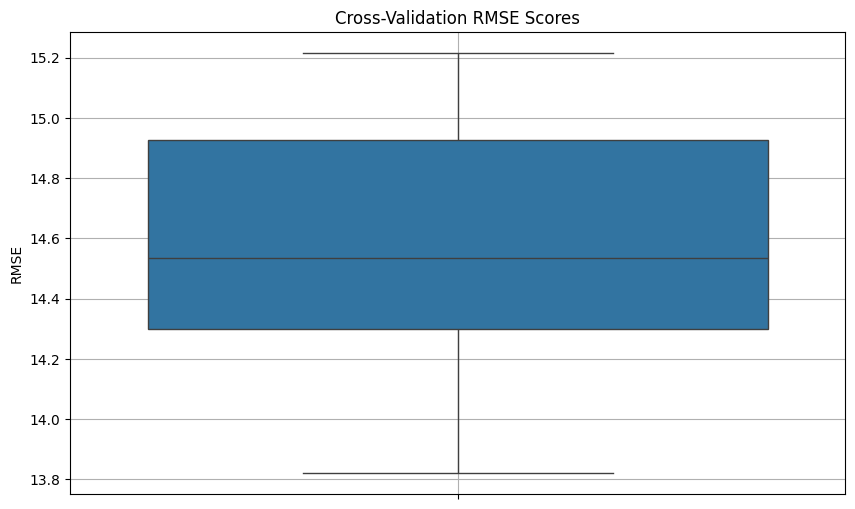

In [17]:
# Plot cross-validation scores
plot_cross_val_scores(best_model, X_train, y_train)

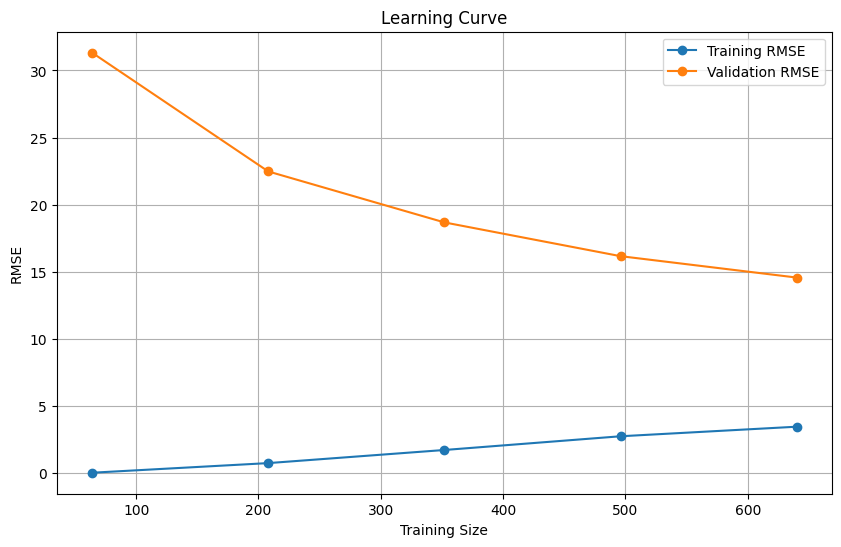

In [18]:
# Plot learning curve
plot_learning_curve(best_model, X_train, y_train)


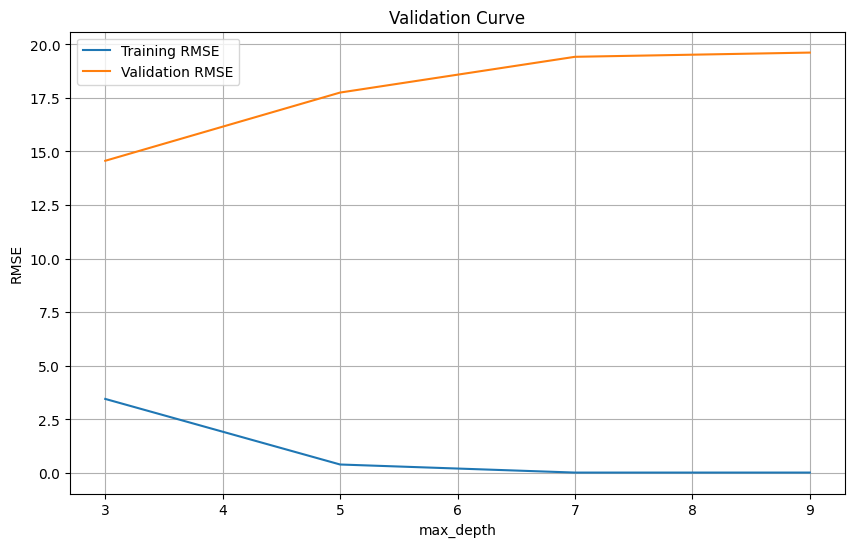

In [19]:
# Plot validation curve for a specific parameter (e.g., 'max_depth')
param_name = 'max_depth'
param_range = [3, 5, 7, 9]
plot_validation_curve(best_model, X_train, y_train, param_name, param_range)

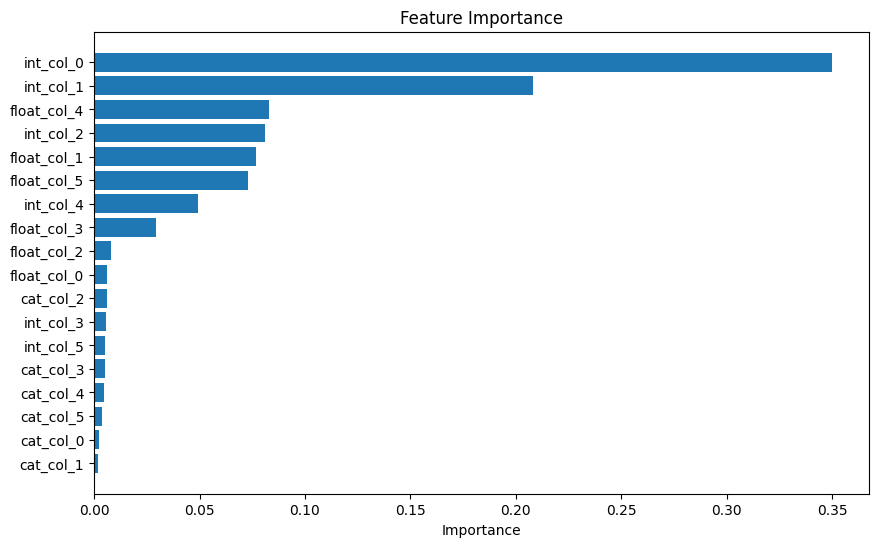

In [20]:
# Plot feature importance
plot_feature_importance(best_model, X_train.columns.tolist(), max_num=20)

In [21]:
def run_model(model_name, X_train, X_test, y_train, y_test, params=None):
    """
    Run a single model with error handling and basic parameter tuning.
    """
    try:
        print(f"\nRunning {model_name}...")
        
        # Create base model
        model = create_model(model_name)
        
        # Get default params if none provided
        if params is None:
            if model_name in param_grids:
                params = {k: v[0] if isinstance(v, list) else v 
                         for k, v in param_grids[model_name.lower()].items()}
            else:
                params = {}
        
        # Handle categorical features for models that need it
        X_train_prep = X_train.copy()
        X_test_prep = X_test.copy()
        
        # Drop text columns since they're random and not useful for prediction
        text_cols = X_train_prep.select_dtypes(include=['object']).columns
        X_train_prep = X_train_prep.drop(columns=text_cols)
        X_test_prep = X_test_prep.drop(columns=text_cols)
        
        # One-hot encode categorical columns
        cat_cols = X_train_prep.select_dtypes(include=['category']).columns
        for col in cat_cols:
            # Get all unique categories from both train and test
            all_categories = pd.concat([X_train_prep[col], X_test_prep[col]]).unique()
            # Create binary columns for each category
            for category in all_categories:
                col_name = f"{col}_{category}"
                X_train_prep[col_name] = (X_train_prep[col] == category).astype(int)
                X_test_prep[col_name] = (X_test_prep[col] == category).astype(int)
            # Drop original categorical column
            X_train_prep = X_train_prep.drop(columns=[col])
            X_test_prep = X_test_prep.drop(columns=[col])
        
        # Convert datetime to numeric
        for col in X_train_prep.select_dtypes(include=['datetime64']).columns:
            X_train_prep[col] = X_train_prep[col].astype(np.int64)
            X_test_prep[col] = X_test_prep[col].astype(np.int64)
        
        # Ensure all remaining columns are numeric
        X_train_prep = X_train_prep.astype(float)
        X_test_prep = X_test_prep.astype(float)
        
        # Create and train model
        model = create_model(model_name, params)
        model.fit(X_train_prep, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_prep)
        
        # Calculate metrics
        metrics = calculate_metrics(y_test, y_pred)
        
        return {"status": "success", "model": model, "metrics": metrics}
    
    except Exception as e:
        return {"status": "error", "model_name": model_name, "error": str(e)}


In [22]:
# Run all models
all_models = [
    "LinearRegression",
    "Lasso",
    "Ridge",
    "ElasticNet",
    "RandomForest",
    "SVR",
    "KNeighbors",
    "AdaBoost",
    "Bagging",
    "XGBoost",
    "GradientBoosting"
]

results = {}
for model_name in all_models:
    # Basic configurations for each model
    if model_name == "RandomForest":
        params = {'n_estimators': 100, 'max_depth': 5, 'n_jobs': -1}
    elif model_name == "XGBoost":
        params = {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'tree_method': 'hist', 'n_jobs': -1}
    elif model_name == "SVR":
        params = {'kernel': 'rbf', 'C': 1.0, 'epsilon': 0.1}
    else:
        params = None
        
    result = run_model(model_name, X_train, X_test, y_train, y_test, params)
    results[model_name] = result
    
    if result["status"] == "success":
        print(f"\n{model_name} Results:")
        for metric, value in result["metrics"].items():
            print(f"{metric}: {value:.4f}")
    else:
        print(f"\n{model_name} Error:")
        print(result["error"])

# Find best model among successful ones
successful_models = {
    name: result["metrics"]["R2"] 
    for name, result in results.items() 
    if result["status"] == "success"
}

if successful_models:
    best_model = max(successful_models.items(), key=lambda x: x[1])
    print(f"\nBest Model: {best_model[0]} (R2: {best_model[1]:.4f})")
else:
    print("\nNo models completed successfully")



Running LinearRegression...

LinearRegression Results:
RMSE: 0.9827
R2: 0.9998
MAE: 0.7628
Explained Variance: 0.9998

Running Lasso...

Lasso Results:
RMSE: 1.0185
R2: 0.9998
MAE: 0.7686
Explained Variance: 0.9998

Running Ridge...

Ridge Results:
RMSE: 0.9826
R2: 0.9998
MAE: 0.7627
Explained Variance: 0.9998

Running ElasticNet...

ElasticNet Results:
RMSE: 1.0093
R2: 0.9998
MAE: 0.7659
Explained Variance: 0.9998

Running RandomForest...

RandomForest Results:
RMSE: 29.1680
R2: 0.8111
MAE: 23.2702
Explained Variance: 0.8112

Running SVR...

SVR Results:
RMSE: 45.6927
R2: 0.5365
MAE: 37.6836
Explained Variance: 0.5379

Running KNeighbors...

KNeighbors Results:
RMSE: 29.7371
R2: 0.8037
MAE: 23.8336
Explained Variance: 0.8039

Running AdaBoost...

AdaBoost Results:
RMSE: 26.7493
R2: 0.8412
MAE: 21.2854
Explained Variance: 0.8412

Running Bagging...

Bagging Results:
RMSE: 25.5546
R2: 0.8550
MAE: 20.6018
Explained Variance: 0.8550

Running XGBoost...

XGBoost Results:
RMSE: 15.0219
R2: